In [1]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from IPython.core.display import Image
import pydot
import io
import matplotlib.pylab as plt
import matplotlib as mpl
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm
import scipy.stats
import scipy as sp
import warnings
warnings.filterwarnings(action='ignore')

# 한글 나오도록 설정하기
set(sorted([f.name for f in mpl.font_manager.fontManager.ttflist]))
# 폰트 설정
mpl.rc('font', family='NanumGothic')
# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

##  2호선 지하철 수요 예측                                           
```








                                                                안준한 박준혁 서희수
```

### 연구배경

- 잘못 추정된 지하철역별 수요는 노선 건설에 대한 경제적 타당성을 비롯하여 역사 규모 설계, 운영상 적자 발생 등의 영향을 미침.


- 지하철역의 경우 건설 후 변경이 어려우므로 더욱 정확한 예측이 필요하지만 내,외부적 다양한 요인으로 인하여 정확한 예측이 어려운 상황.

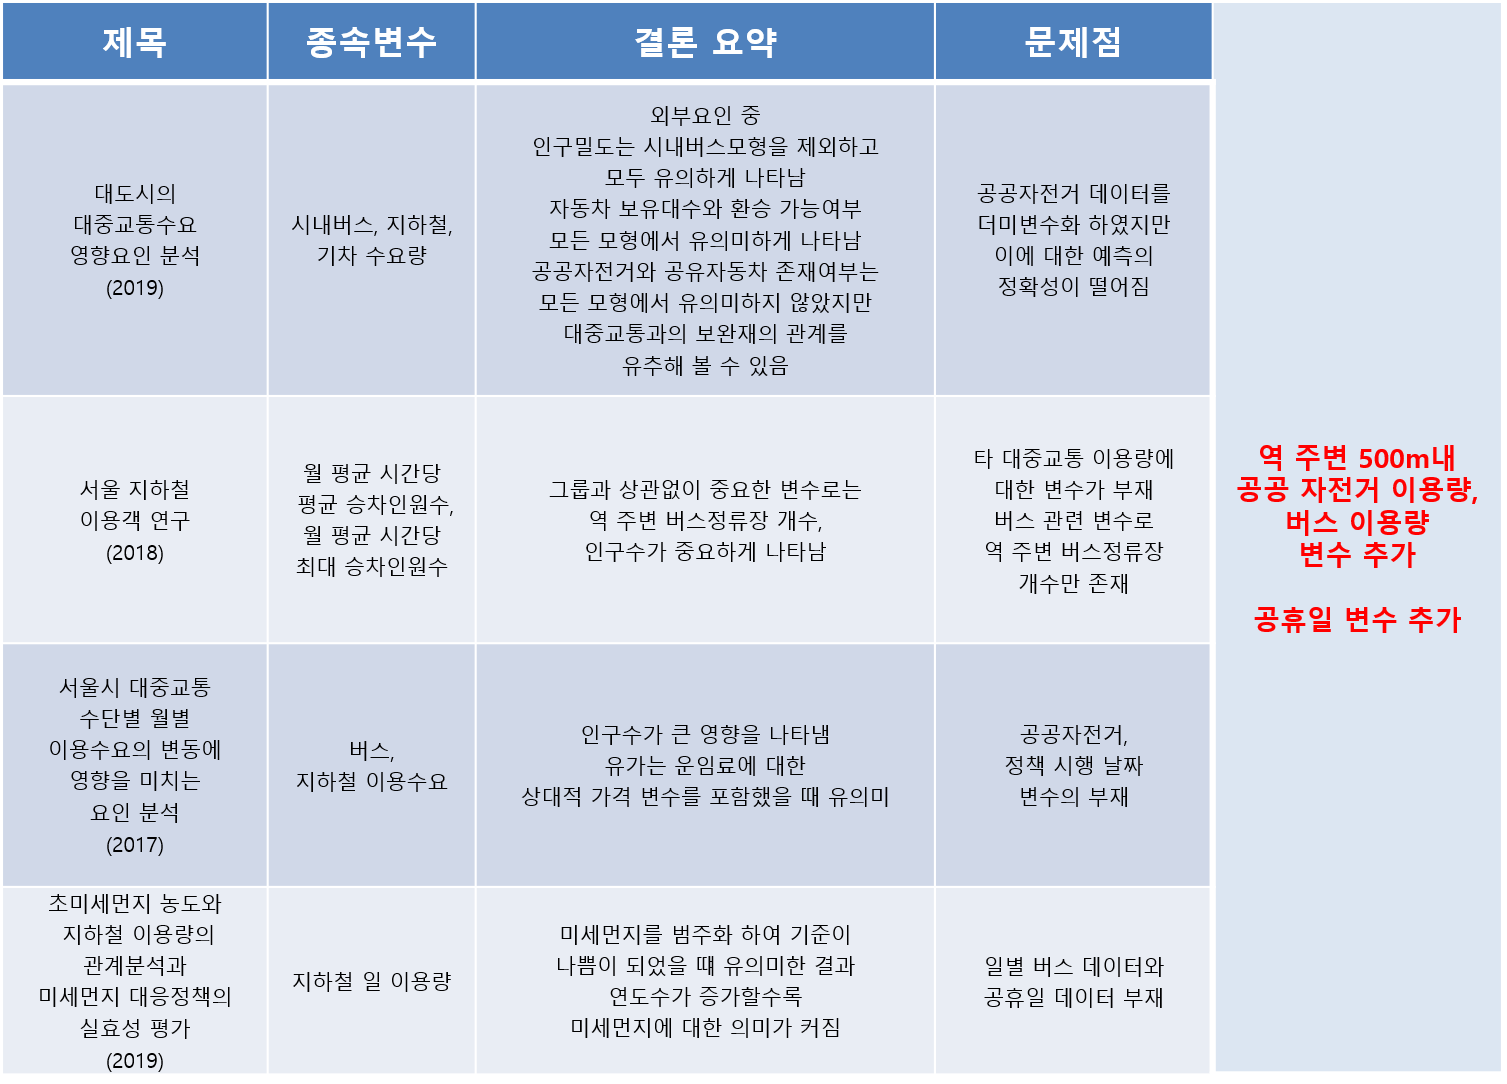

In [245]:
Image("논문.png")

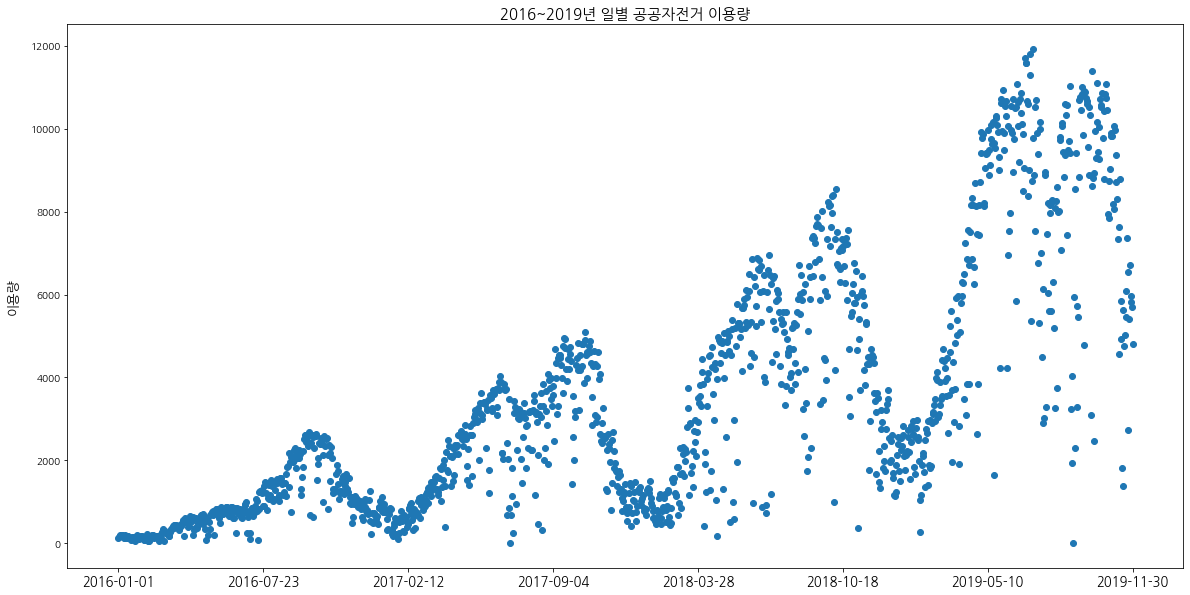

In [18]:
subway_plot1('bike', '공공자전거')

In [55]:
# 역별 일평균 지하철 이용량과 자전거 이용량 비교를 위한 groupby
# minmax를 적용했는데 역별로 min과 max가 다른데,,,역별로 적용해야하는것이 아닌지,,
from sklearn import preprocessing
group_gu = sub2_all.groupby(['역명','날짜']).mean().reset_index()[['역명','날짜','total','bike']]
mm = preprocessing.MinMaxScaler()
group_gu[['total','bike']] = mm.fit_transform(group_gu[['total','bike']])

In [79]:
def subVSbike(name):
    plt.figure(figsize=(20, 10))
    plt.subplot(111)
    plt.scatter(x=group_gu[group_gu['역명']==name]['날짜'],
                y=group_gu[group_gu['역명']==name]['total'])
    plt.subplot(111)
    plt.scatter(x=group_gu[group_gu['역명']==name]['날짜'],
                y=group_gu[group_gu['역명']==name]['bike'],)
    plt.xlabel('날짜', labelpad=10)
    plt.xticks(np.linspace(0, 1429, 8), fontsize=13)
    plt.title('{}역 일평균 지하철및 공공자전거 이용량'.format(name))
    plt.show()

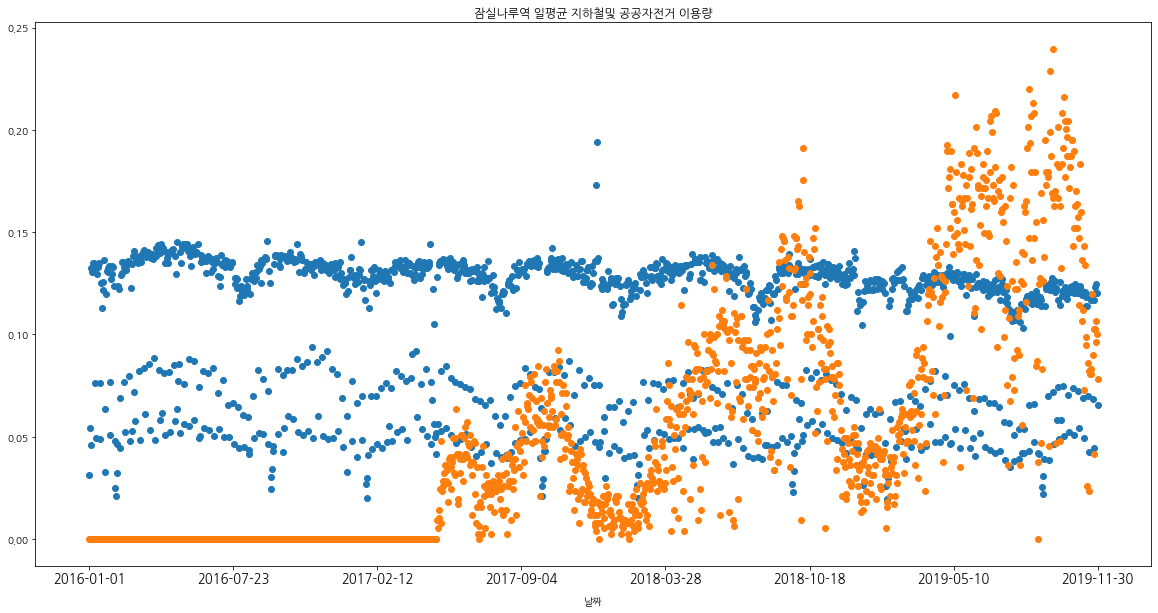

In [111]:
subVSbike('잠실나루')

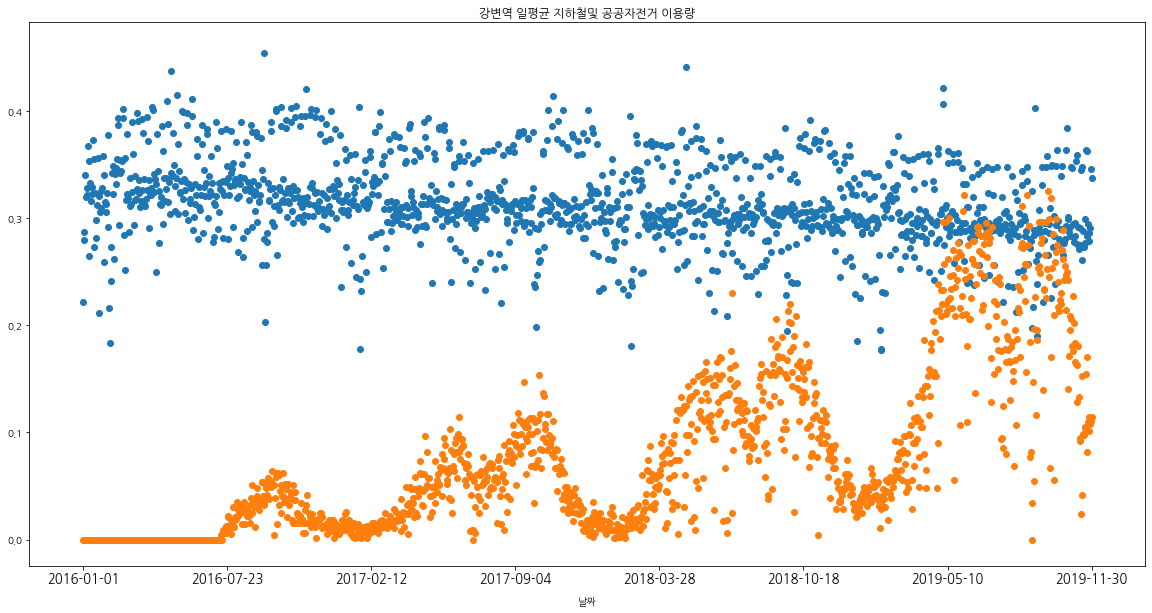

In [82]:
subVSbike('강변')

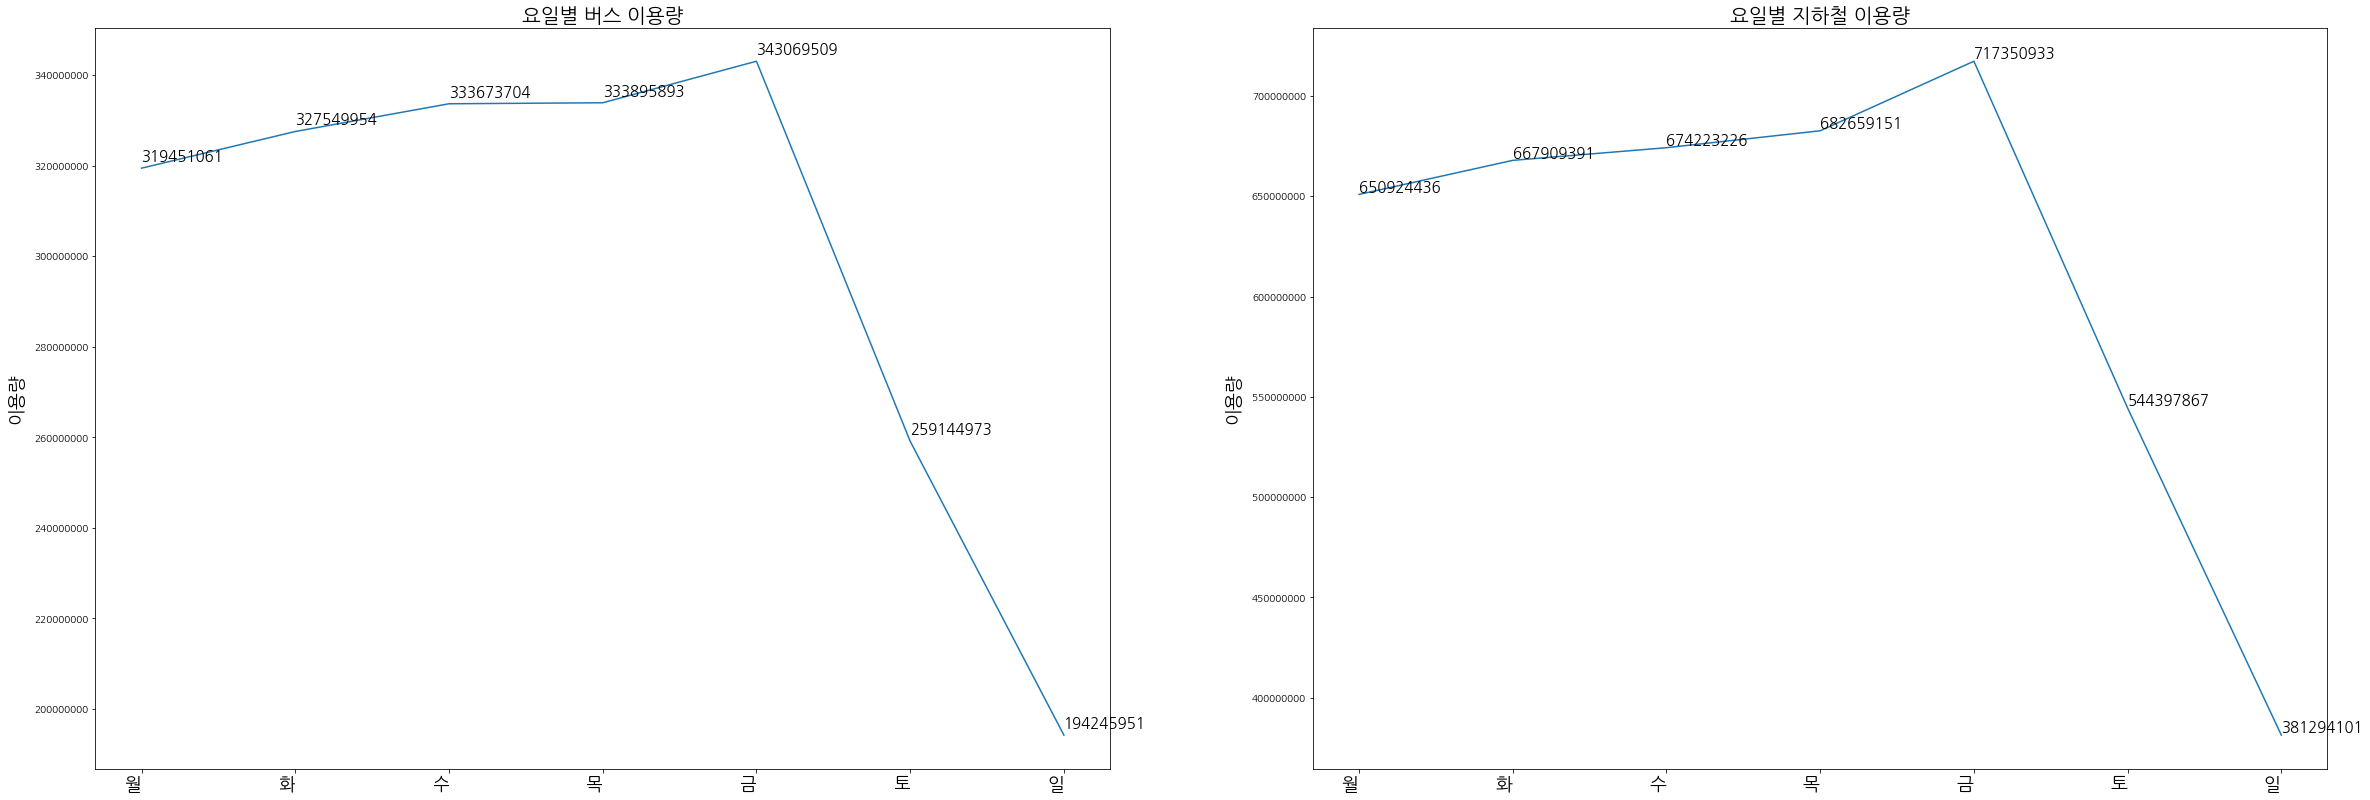

In [24]:
%matplotlib inline
plt.figure(figsize=(40, 30))
plt.subplot(221);subway_plot2('버스 이용', 'bus', 1750000)
plt.subplot(222);subway_plot2('지하철 이용', 'total', 1750000);plt.show()

### 가설

- 대체 교통수단 이용량과 역별 지하철 수요량의 선형관계를 찾을 수 있을 것이다.

### 활용 데이터 셋


* 서울교통공사 지하철역 주소 및 전화번호 정보 (http://www.seoulmetro.co.kr/kr/board.do?menuIdx=551&bbsIdx=2208459)

* 서울시 구별 기상 데이터 (https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36)

* 서울시 대기질 정보 (http://data.seoul.go.kr/dataList/OA-15515/S/1/datasetView.do) **API 활용**

* 공휴일 여부 (http://me2.do/5uOupdMO) **API활용**

* 서울시 버스정류장 수(https://data.seoul.go.kr/dataList/OA-686/C/1/datasetView.do)

* 서울특별시 공공자전거 이용정보(시간대별)(https://data.seoul.go.kr/dataList/OA-15245/F/1/datasetView.do) 

* 서울특별시 공공자전거 대여소 정보(https://data.seoul.go.kr/dataList/OA-13252/F/1/datasetView.do) (https://www.bikeseoul.com/app/station/moveStationSearchView.do?currentPageNo=383&stationGrpSeq=) **대여소 crawling**

* 서울시 버스노선별 정류장별 승하차 인원 정보(https://data.seoul.go.kr/dataList/OA-12912/S/1/datasetView.do#)

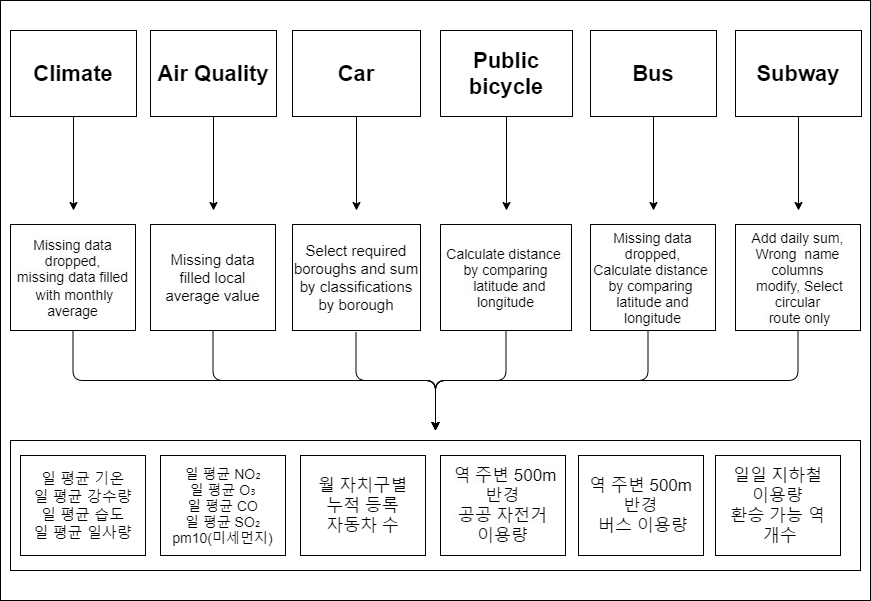

In [317]:
Image('first_v5.png')

### 데이터 전처리

In [2]:
sub2 = pd.read_csv('sub2.csv', encoding='euc-kr')
air_avgday = pd.read_csv('air_avgday.csv', encoding='euc-kr')
tem = pd.read_csv('tem.csv', encoding='euc-kr')
bike_count = pd.read_csv('bike_count.csv', encoding='euc-kr')
bus_sum = pd.read_csv('bus_sum.csv', encoding='euc-kr')
sub2_in = pd.read_csv('sub2_in.csv', encoding='euc-kr')
sub2_out = pd.read_csv('sub2_out.csv', encoding='euc-kr')
sub2_all = pd.read_csv('sub2_all.csv', encoding='euc-kr')

In [3]:
sub2_in = sub2_in[~((sub2_in['year'] == 2019) & (sub2_in['month'] == 12))]
sub2_out = sub2_out[~((sub2_out['year'] == 2019) & (sub2_out['month'] == 12))]

In [4]:
sub2.tail()

날짜  역번호   역명  구분  total  17to20  year  month 요일   holi  \
125641  2019-12-31  241   이대  하차  18833    3361  2019     12  화  False   
125642  2019-12-31  242   아현  승차  11065    1998  2019     12  화  False   
125643  2019-12-31  242   아현  하차  10524    2858  2019     12  화  False   
125644  2019-12-31  243  충정로  승차  10987    3218  2019     12  화  False   
125645  2019-12-31  243  충정로  하차  11536    2016  2019     12  화  False   

        ctransfer     구      동  
125641          0   마포구    염리동  
125642          0   마포구    아현동  
125643          0   마포구    아현동  
125644          1  서대문구  충정로3가  
125645          1  서대문구  충정로3가

In [5]:
air_avgday.tail()

msrdt msrste_nm    no2     o3     co    so2    pm10    pm25  권역코드
36514  20190908       용산구  0.020  0.031  0.446  0.004  29.833  22.667   100
36515  20190908       은평구  0.014  0.039  0.604  0.004  39.292  25.458   101
36516  20190908       종로구  0.015  0.030  0.454  0.003  32.542  20.750   100
36517  20190908        중구  0.016  0.035  0.450  0.003  33.208  19.750   100
36518  20190908       중랑구  0.014  0.030  0.483  0.005  30.042  19.458   102

In [6]:
tem.tail()

date  avgtemp  rainfall  avghumidity  solar  year  month
1456  2016-12-27     -2.3       0.5         54.6   9.29  2016     12
1457  2016-12-28     -3.7       0.0         49.0   9.22  2016     12
1458  2016-12-29     -4.2       0.3         53.1   9.67  2016     12
1459  2016-12-30     -3.9       0.0         50.9   6.79  2016     12
1460  2016-12-31      0.7       0.0         65.4   5.28  2016     12

In [3]:
import folium
import json
regis2 = pd.read_csv('regis2.csv', encoding='euc-kr')
m = folium.Map(location=[37.5051, 126.97], zoom_start=12)

for i in regis2.index[:1000]:
    folium.Circle(
        location=regis2.loc[i, ['X좌표(WGS)', 'Y좌표(WGS)']],
        tooltip=regis2.loc[i, 'busstation500m'],
        radius=500).add_to(m)

In [4]:
m

In [9]:
bus_sum.tail()

사용일자  ARS-ID          x           y  승차총승객수  하차총승객수
1119056  20191130   24155  37.510178  127.078506     469     340
1119057  20191130   24158  37.511407  127.084495    4373    1876
1119058  20191130   24164  37.509857  127.079037     184     831
1119059  20191130   24436  37.508924  127.086584     547     206
1119060  20191130   24458  37.510422  127.086038     164    1233

In [10]:
bike_count.tail()

대여일시  대여소번호  count
1274059  2019-11-30   3537     17
1274060  2019-11-30   3538     10
1274061  2019-11-30   3539      3
1274062  2019-11-30   3541     73
1274063  2019-11-30   3542     37

In [11]:
sub2_all.tail()

날짜    역명  in_total  year  month 요일  holi  ctransfer     구  \
61485  2019-11-30  홍대입구     99997  2019     11  토  True          2   마포구   
61486  2019-11-30    신촌     52735  2019     11  토  True          0   마포구   
61487  2019-11-30    이대     19636  2019     11  토  True          0   마포구   
61488  2019-11-30    아현      9792  2019     11  토  True          0   마포구   
61489  2019-11-30   충정로      8794  2019     11  토  True          1  서대문구   

       avgtemp  ...  pm10  pm25  bike  bus_in  bus_out     car  out_total  \
61485      4.1  ...  48.0  32.0   199   34808    33757  117932     113309   
61486      4.1  ...  48.0  32.0   242   32226    28383  117932      54320   
61487      4.1  ...  48.0  32.0    46   12674    14341  117932      20514   
61488      4.1  ...  48.0  32.0    69   12909    12230  117932       9103   
61489      4.1  ...  40.0  19.0    44    7966     9275   87171       8998   

           bus   total   분기  
61485  68565.0  213306  4분기  
61486  60609.0  107055  4분기  
61487  27015.0   40150  4분기  
61488  25139.0   18895  4분기  
61489  17241.0   17792  4분기  

[5 rows x 27 columns]

### EDA

In [12]:
sub = sub2_all.groupby('역명').mean().reset_index()[['역명', 'total']]
sub.total = sub.total.round(0).astype(int)
sub = sub.sort_values('total', ascending=False).reset_index(
    drop=True).iloc[:10, :]

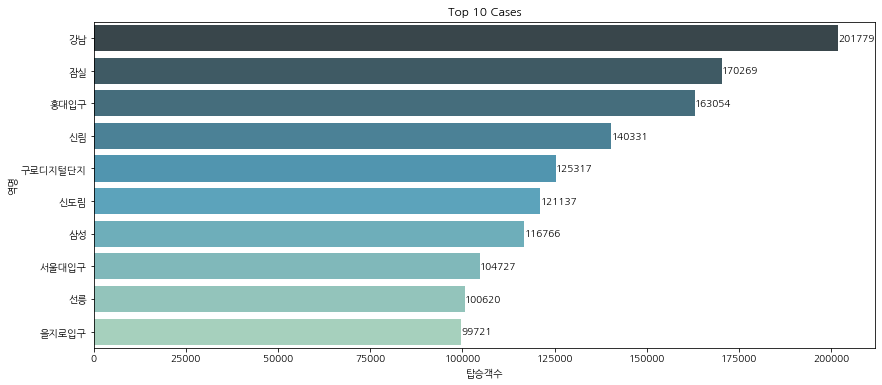

In [13]:
plt.figure(figsize=(14, 6))
sns.barplot(x="total", y='역명', data=sub, palette="GnBu_d")
plt.xlabel("탑승객수")
plt.ylabel("역명")
plt.title("Top 10 Cases")
for value, index in zip(sub['total'], np.linspace(0, 19, 20)):
    plt.text(value+20, index+0.1, str(value))

In [14]:
sub2_plot = sub2_all[['날짜', 'bike', 'total', 'bus_in', 'bus_out']]
grouped = pd.DataFrame(sub2_plot.groupby(sub2_plot['날짜']).sum()).reset_index()

In [15]:
grouped2 = sub2_all.groupby(['날짜', 'holi']).agg({'bike': 'sum',
                                                 'total': 'sum',
                                                 'bus_in': 'sum',
                                                 'bus_out': 'sum'}).reset_index()

In [16]:
def subway_plot1(a, b):
    plt.figure(figsize=(20, 10))
    txt1 = '일별 '+b+' 이용량'
    txt2 = '2016~2019년 일별 '+b+' 이용량'
    plt.scatter(x=grouped['날짜'], y=grouped[a], label=txt1)

    plt.title(txt2, fontsize=15)
    plt.ylabel('이용량', labelpad=10, fontsize=13)
    plt.xticks(np.linspace(0, 1429, 8), fontsize=13)

    plt.show()

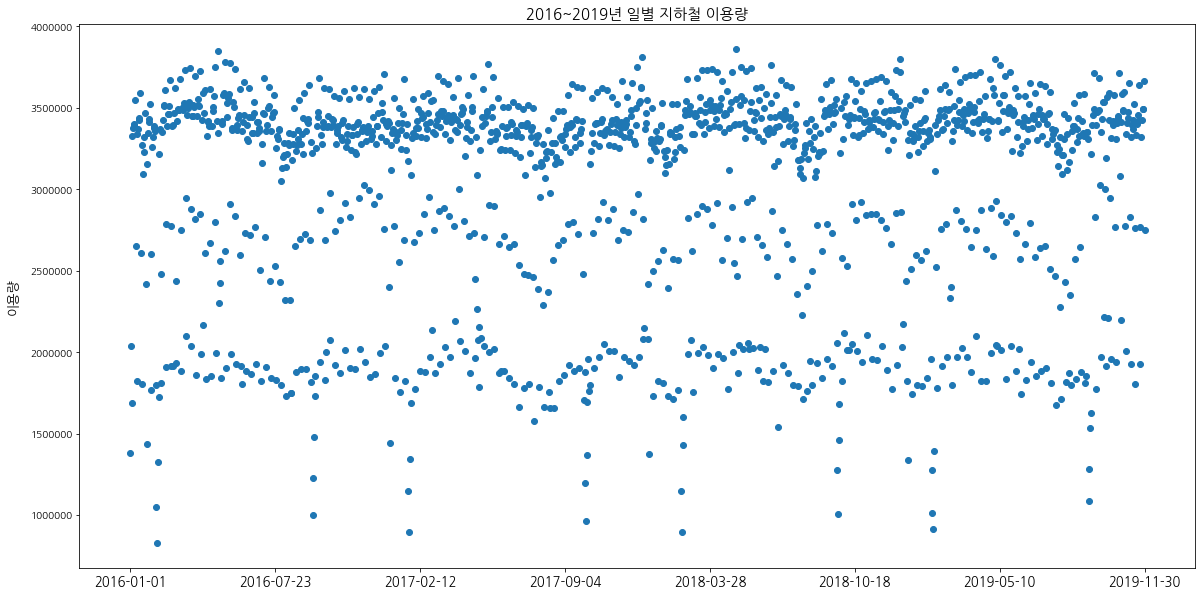

In [17]:
subway_plot1('total', '지하철')

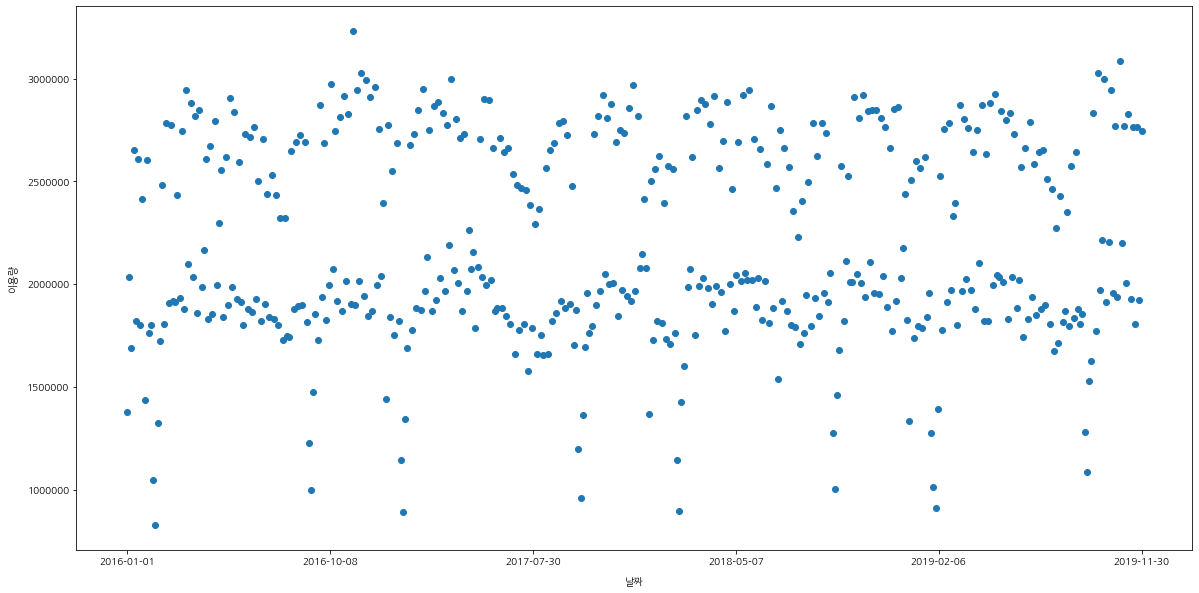

In [18]:
plt.figure(figsize=(20, 10))
plt.scatter(x=grouped2[grouped2["holi"] == True]['날짜'],
            y=grouped2[grouped2["holi"] == True]['total'])
plt.xlabel('날짜', labelpad=10)
plt.ylabel('이용량', labelpad=10)
plt.xticks(np.linspace(0, 463, 6))
plt.show()

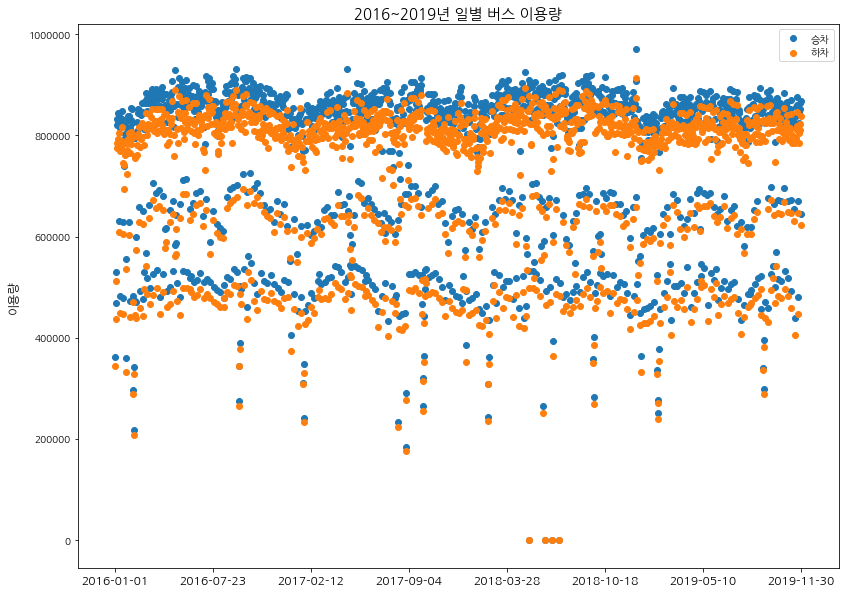

In [25]:
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.scatter(x=grouped['날짜'], y=grouped['bus_in'], label='일별 버스 승차량')
plt.scatter(x=grouped['날짜'], y=grouped['bus_out'], label='일별 버스 하차량')
plt.legend(['승차', '하차'])
plt.title('2016~2019년 일별 버스 이용량', fontsize=15)
plt.ylabel('이용량', labelpad=10, fontsize=12)
plt.xticks(np.linspace(0, 1429, 8), fontsize=12)
plt.show()

In [22]:
# sub2_in_plot = sub2_in_f[['날짜','요일','bus_in','bus_out','bike','total']]
grouped3 = sub2_all.groupby('요일').sum().reset_index()
grouped4 = grouped3.reindex(index=[3, 6, 2, 1, 0, 5, 4]).reset_index()
grouped4.drop(columns='index', inplace=True)

In [23]:
grouped4.bus = grouped4.bus.round(0).astype(int)

In [20]:
def subway_plot2(a, b, c):
    txt = '요일별 '+a+'량'
    plt.title(txt, fontsize=20)
    plt.plot(grouped4.요일, grouped4[b])
    axes = plt.gca()
    axes.get_yaxis().get_major_formatter().set_scientific(False)
    axes.set_xticks(range(len(grouped4.요일)))
    axes.set_xticklabels(grouped4.요일, fontsize=18, ha="right")
    # axes.set_yticks(range(80000000,200000000))
    for i, j in enumerate(grouped4[b]):
        plt.annotate(str(j), xy=(i, j+c), fontsize=15)
    plt.ylabel('이용량', labelpad=10, fontsize=18)

In [230]:
data = sub2_all.iloc[:, [3, 6, 7, 8, 9, 10, 11,
                         12, 13, 14, 15, 16, 17, 18, 19, 22, 24, 25]]

In [569]:
data2 = data[:]
data2.holi = data2.holi.astype('str')

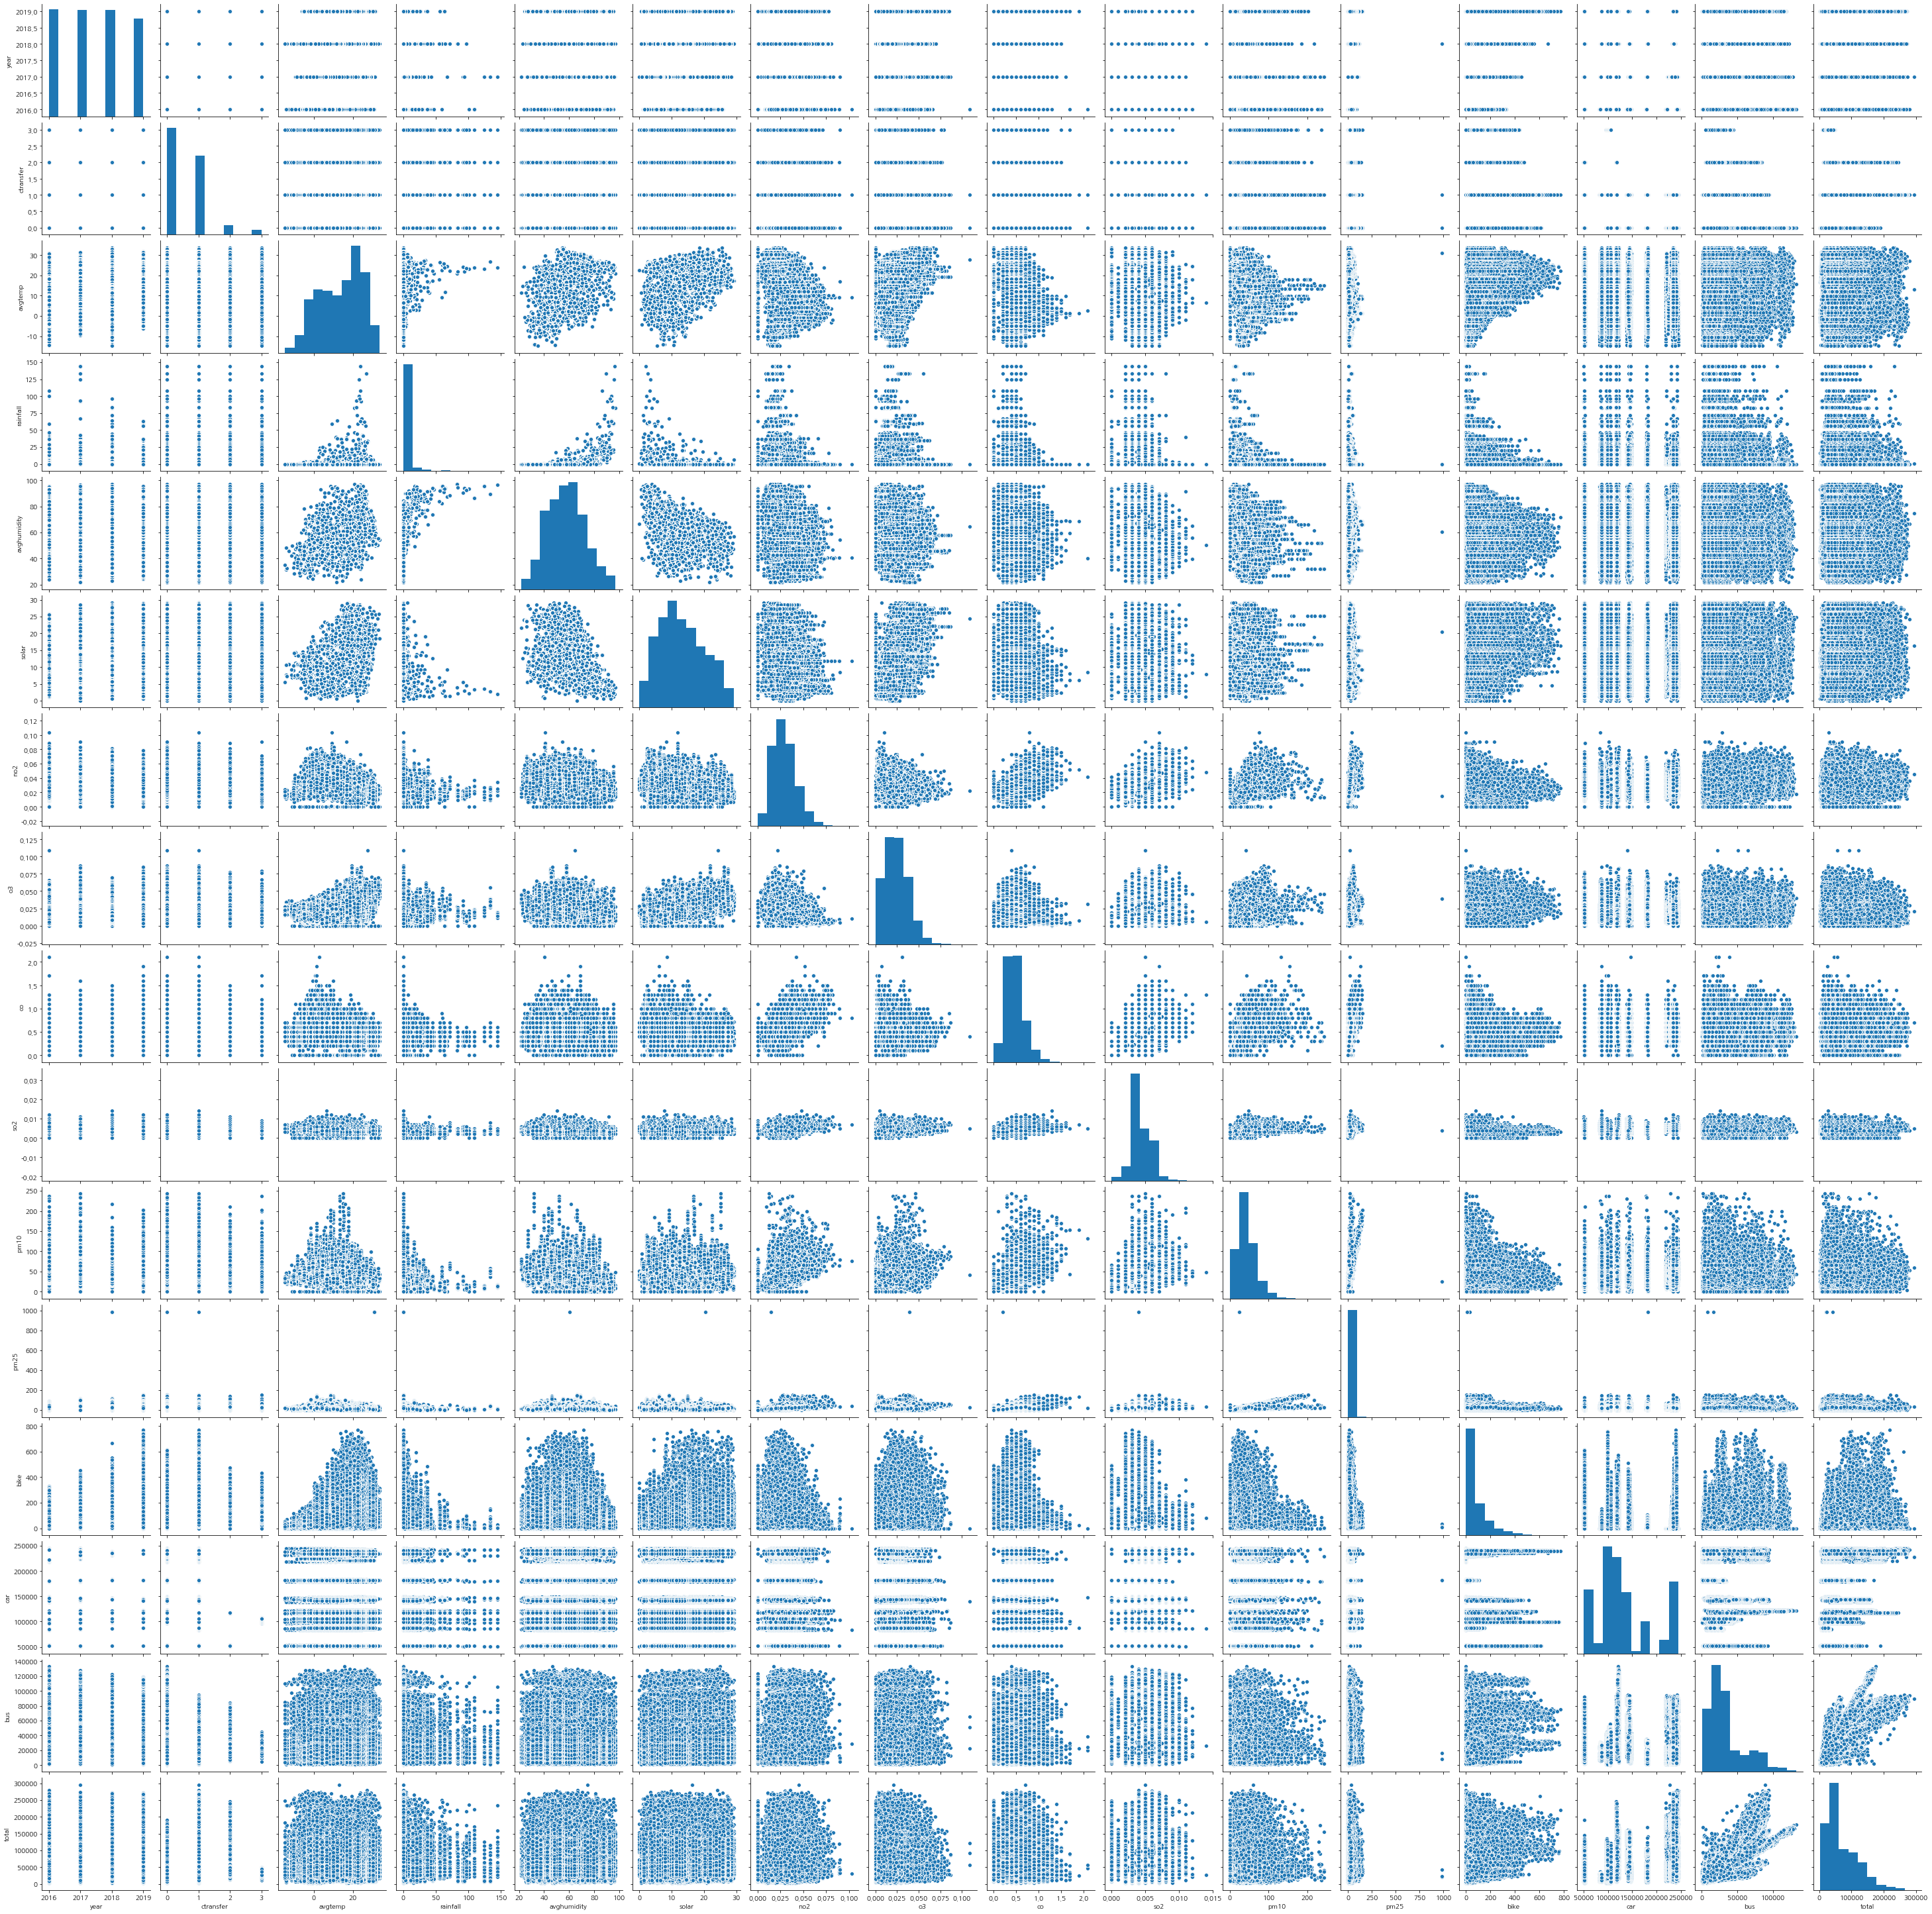

In [570]:
sns.pairplot(data2)
plt.show()

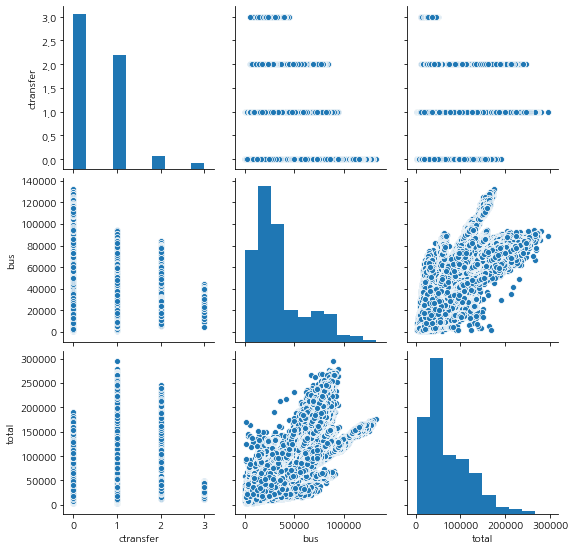

In [560]:
sns.pairplot(data, vars=['ctransfer', 'bus', 'total'])
plt.show()

### Modeling

#### 전체 모형

In [31]:
model1 = sm.OLS.from_formula(
    'total~C(구)+C(holi)+scale(avgtemp)+scale(rainfall)+scale(avghumidity)+scale(solar)+scale(no2)+scale(o3)+scale(co)+scale(so2)+scale(pm10)+scale(bike)+scale(car)+scale(bus)+C(ctransfer)', data=sub2_all)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                 1.030e+04
Date:                Sat, 04 Jul 2020   Prob (F-statistic):               0.00
Time:                        15:55:32   Log-Likelihood:            -6.9710e+05
No. Observations:               61490   AIC:                         1.394e+06
Df Residuals:                   61462   BIC:                         1.395e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.301e+05   3084

#### 자치구와 휴일의 상호작용

In [34]:
data3 = data.groupby(['구', 'holi']).mean().reset_index()[
    ['구', 'holi', 'total']]

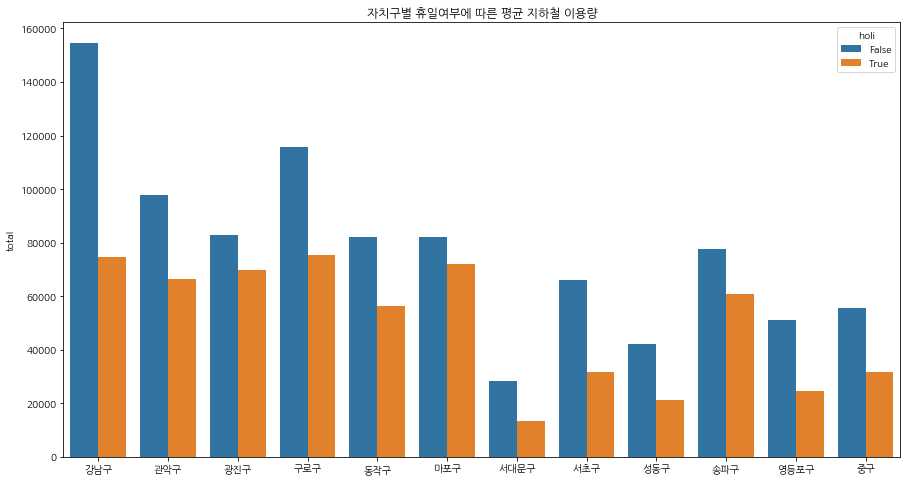

In [35]:
plt.figure(figsize=(15, 8))
sns.barplot(x='구', y='total', hue='holi', data=data3)
plt.title('자치구별 휴일여부에 따른 평균 지하철 이용량')
plt.xlabel("")
plt.show()

In [273]:
model2 = sm.OLS.from_formula(
    'total~C(구):C(holi)+scale(avgtemp)+scale(rainfall)+scale(avghumidity)+scale(solar)+scale(no2)+scale(co)+scale(so2)+scale(pm10)+scale(bike)+scale(car)+scale(bus)+C(ctransfer)', data=sub2_all)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     8746.
Date:                Mon, 06 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:14:29   Log-Likelihood:            -6.9322e+05
No. Observations:               61490   AIC:                         1.387e+06
Df Residuals:                   61452   BIC:                         1.387e+06
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

#### 구와 버스이용량의 상호작용

In [38]:
data3 = data.groupby('구').mean().reset_index()[['구', 'bus', 'total']]

<Figure size 4320x4320 with 0 Axes>

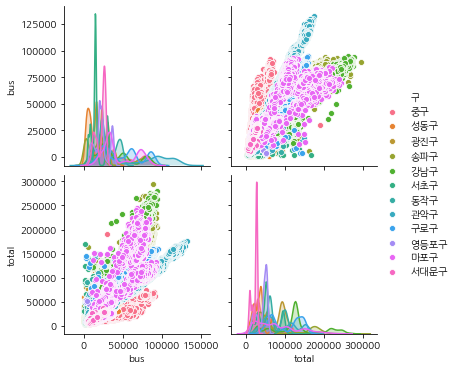

In [40]:
plt.figure(figsize=(60, 60))
sns.pairplot(hue='구', data=data, vars=['bus', 'total'])
plt.show()

In [254]:
model3 = sm.OLS.from_formula(
    'total ~ C(구):(C(holi)+scale(bus))+C(ctransfer)+scale(bike)+scale(car)+scale(avgtemp)+scale(rainfall)+scale(avghumidity)+scale(solar)+scale(no2)+scale(co)+scale(so2)+scale(pm10)', data=sub2_all)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                 1.015e+04
Date:                Mon, 06 Jul 2020   Prob (F-statistic):               0.00
Time:                        18:52:18   Log-Likelihood:            -6.8232e+05
No. Observations:               61490   AIC:                         1.365e+06
Df Residuals:                   61441   BIC:                         1.365e+06
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

#### 지하철 이용량 예측치와 실제 이용량과의 관계

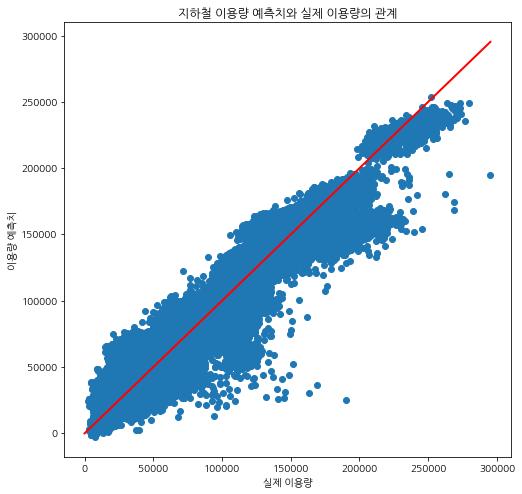

In [310]:
plt.figure(figsize=(8, 8))
y_hat = result3.predict(data)
plt.scatter(data.total, y_hat)
plt.xlabel("실제 이용량");plt.ylabel("이용량 예측치")
plt.title("지하철 이용량 예측치와 실제 이용량의 관계")
plt.plot([0,data.total.max()],[0,data.total.max()],'r',lw=2);plt.show()

### 교차검증

In [284]:
def cross(formula):
    split = sub2_all.year.unique()
    score = pd.DataFrame(
        columns=['year', 'train_R2', 'test_R2', 'adjR2', 'mse', 'rmse'])

    for n, i in enumerate(split):
        df_train = sub2_all[sub2_all.year != i]
        df_test = sub2_all[sub2_all.year == i]

        model = sm.OLS.from_formula(formula, data=df_train)
        result = model.fit()

        pred = result.predict(df_test)
        rsquared = r2_score(df_test.total, pred)
        mse = mean_squared_error(df_test.total, pred)
        rmse = np.sqrt(mse)
        adjR2 = 1-((len(df_test)-1)/(len(df_test) - (len(result.params)-1)))*(1-result.rsquared)
        score.loc[n] = [i, result.rsquared, rsquared, adjR2, mse, rmse]

    return score

In [277]:
def predict_plot(formula, month):
    split = sub2_all.year.unique()

    for n, i in enumerate(split):
        if ((i == 2019) & (month == '12')):
            return
        df_train = sub2_all[sub2_all.year != i]
        df_test = sub2_all[sub2_all.year == i]
        model = sm.OLS.from_formula(formula, data=df_train)
        result = model.fit()
        df_test['pred'] = result.predict(df_test)

        plt.figure(figsize=(30, 40))
        plt.subplot(4, 1, n+1)
        plt.plot(df_test[(df_test.날짜 >= '{}-{}-01'.format(i, month))
                         & (df_test.날짜 <= '{}-{}-07'.format(i, month))].total)
        plt.plot(df_test[(df_test.날짜 >= '{}-{}-01'.format(i, month))
                         & (df_test.날짜 <= '{}-{}-07'.format(i, month))].pred)
        plt.legend(['실제', '예측'], fontsize='xx-large')
        xt = df_test[(df_test.날짜 >= '{}-{}-01'.format(i, month)) &
                     (df_test.날짜 <= '{}-{}-07'.format(i, month))].날짜.unique()
        a = df_test[df_test.날짜 == '{}-{}-01'.format(i, month)].index[0]
        b = df_test[df_test.날짜 == '{}-{}-07'.format(i, month)].index[-1]
        plt.xticks(ticks=np.linspace(a, b, 7), labels=xt, fontsize=16)
        plt.title('{}년 {}월 첫째 주 실제 이용량과 예측 이용량'.format(
            i, int(month)), fontsize=17)
        plt.show()

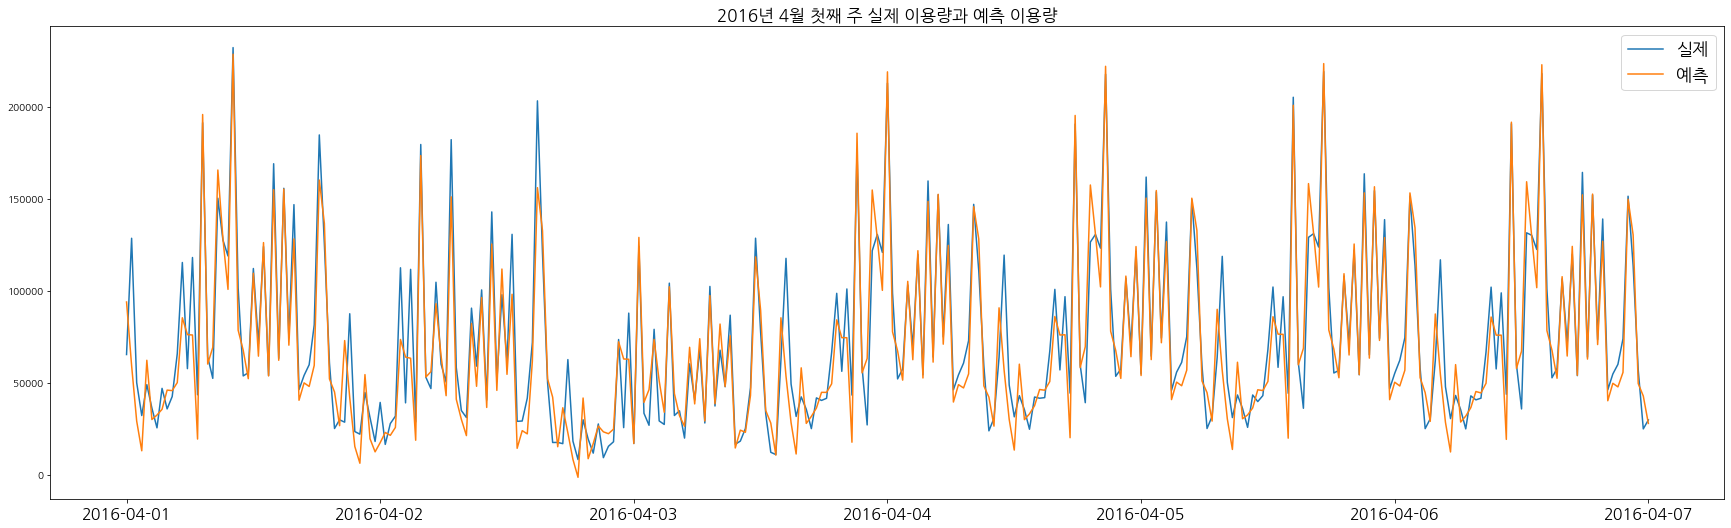

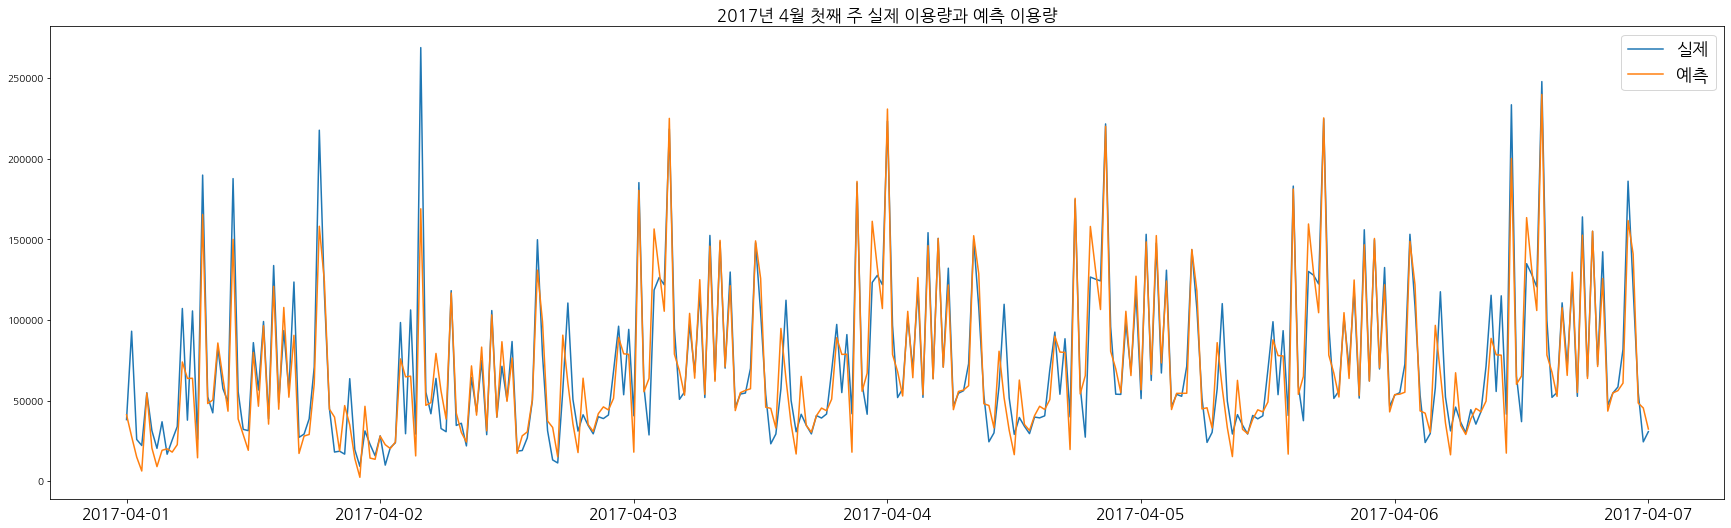

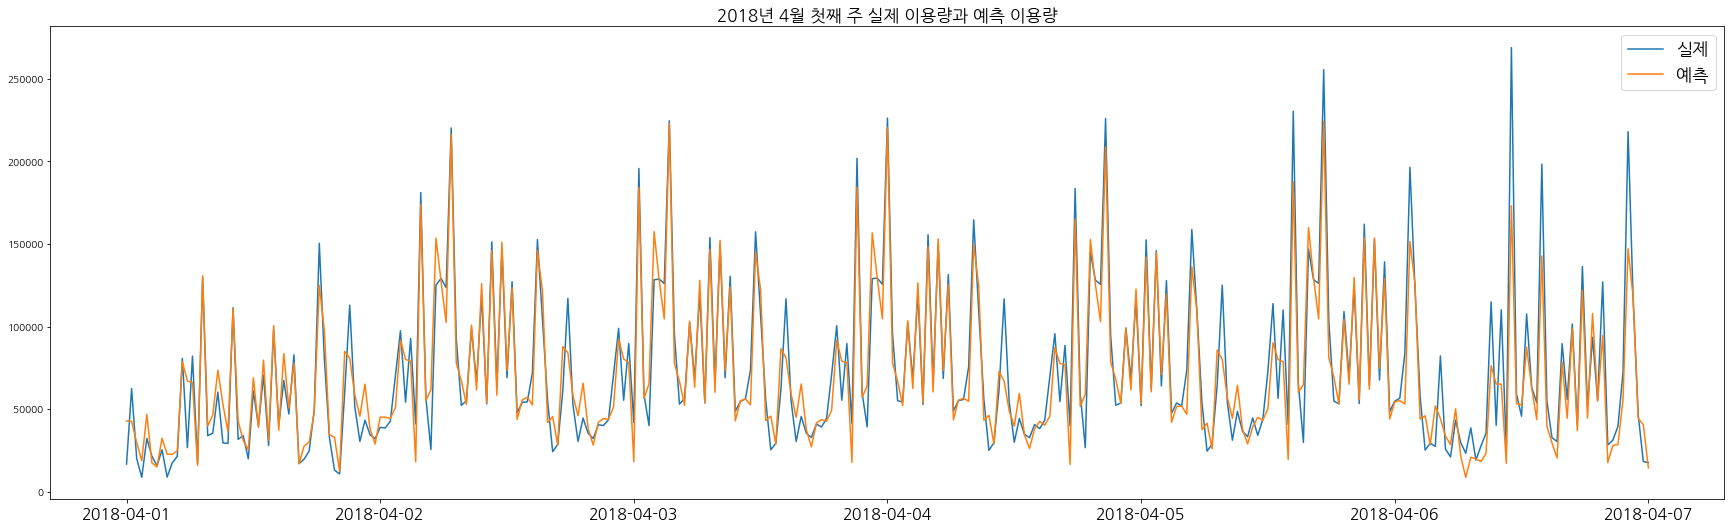

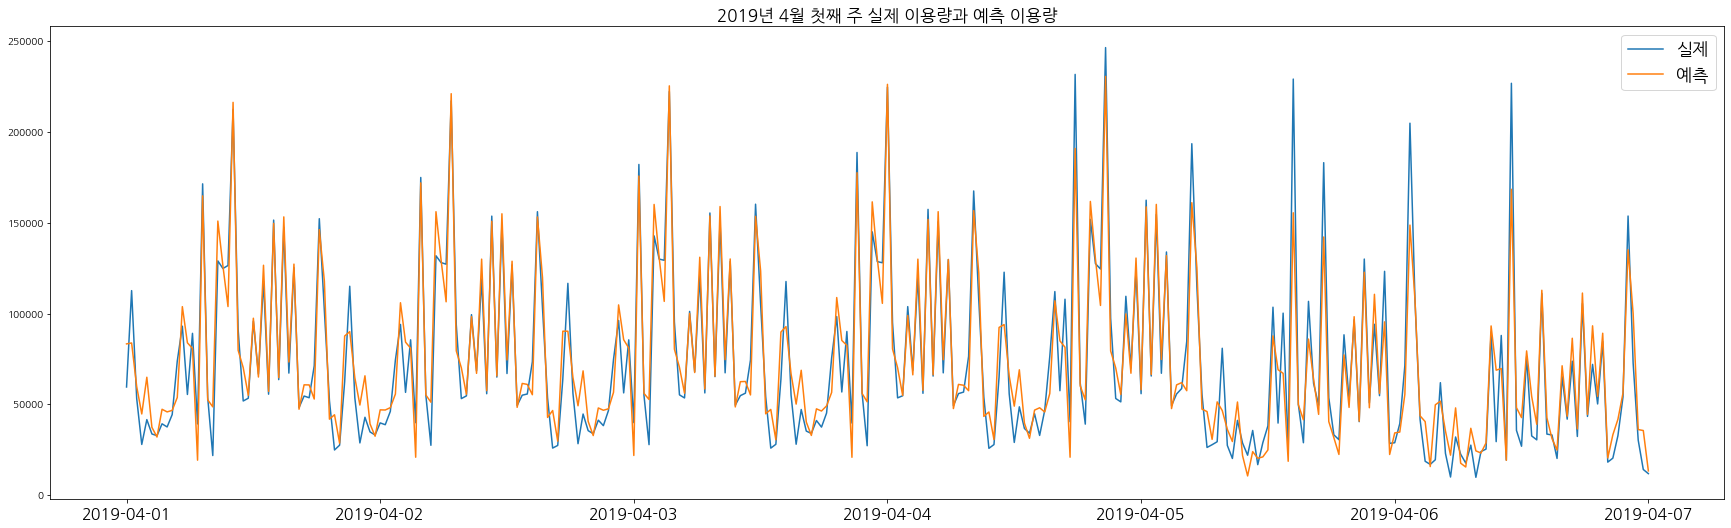

In [224]:
predict_plot('total ~ C(구):(C(holi)+scale(bus))+C(ctransfer)+scale(bike)+scale(car)+scale(avgtemp)+scale(rainfall)+scale(avghumidity)+scale(solar)+scale(no2)+scale(co)+scale(so2)+scale(pm10)', '04')

In [285]:
# 구:holi , 날씨, 대기질, car
score1 = cross('total ~ C(구):C(holi)+C(ctransfer)+scale(car)+scale(avgtemp)+scale(rainfall)+scale(avghumidity)+scale(solar)+scale(no2)+scale(co)+scale(so2)+scale(pm10)')
# score1에서 따릉이 추가된 모형
score2 = cross('total ~ C(구):C(holi)+C(ctransfer)+scale(car)+scale(avgtemp)+scale(rainfall)+scale(avghumidity)+scale(solar)+scale(no2)+scale(co)+scale(so2)+scale(pm10)+scale(bike)')
# score2에서 버스 추가된 모형
score3 = cross('total ~ C(구):C(holi)+C(ctransfer)+scale(car)+scale(avgtemp)+scale(rainfall)+scale(avghumidity)+scale(solar)+scale(no2)+scale(co)+scale(so2)+scale(pm10)+scale(bike)+scale(bus)')
# score3에서 구와 버스 상호작용으로 넣은 모형
score4 = cross('total ~ C(구):(C(holi)+scale(bus))+C(ctransfer)+scale(bike)+scale(car)+scale(avgtemp)+scale(rainfall)+scale(avghumidity)+scale(solar)+scale(no2)+scale(co)+scale(so2)+scale(pm10)')

### 변수 영향력 확인

In [166]:
sm.stats.anova_lm(result3, typ=2)

sum_sq       df             F        PR(>F)
C(ctransfer)        2.787375e+12      3.0   3647.403060  0.000000e+00
C(구):C(holi)        1.102377e+13     23.0   1881.533844  0.000000e+00
C(구):scale(bus)     4.416015e+13     12.0  14446.377952  0.000000e+00
scale(bike)         4.885177e+11      1.0   1917.740864  0.000000e+00
scale(car)          1.023980e+09      1.0      4.019768  4.497429e-02
scale(avgtemp)      9.602956e+10      1.0    376.976781  1.010654e-83
scale(rainfall)     5.089242e+09      1.0     19.978496  7.845778e-06
scale(avghumidity)  1.056376e+10      1.0     41.469453  1.206078e-10
scale(solar)        6.106710e+09      1.0     23.972702  9.795880e-07
scale(no2)          3.740250e+10      1.0    146.828467  9.349363e-34
scale(co)           7.341101e+09      1.0     28.818466  7.977705e-08
scale(so2)          4.787920e+09      1.0     18.795615  1.457324e-05
scale(pm10)         4.675917e+09      1.0     18.355934  1.835256e-05
Residual            1.565124e+13  61441.0           NaN           NaN

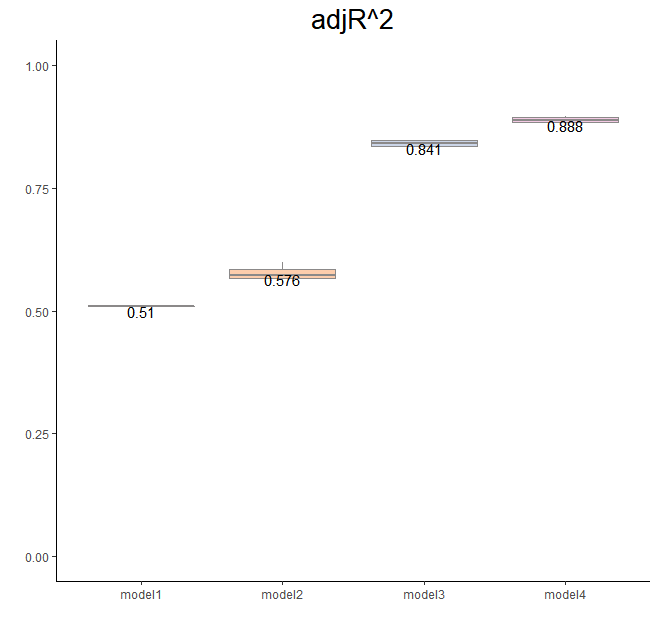

In [296]:
Image("model_adjR2.png")

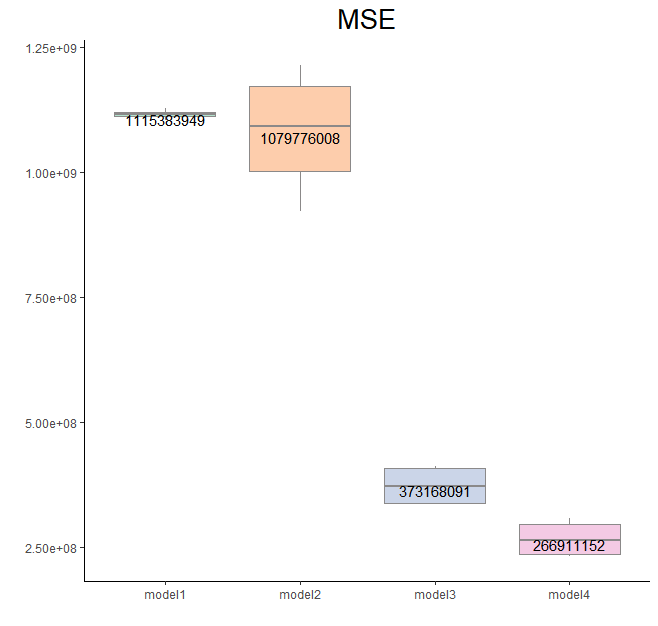

In [316]:
Image("model_MSE.png")

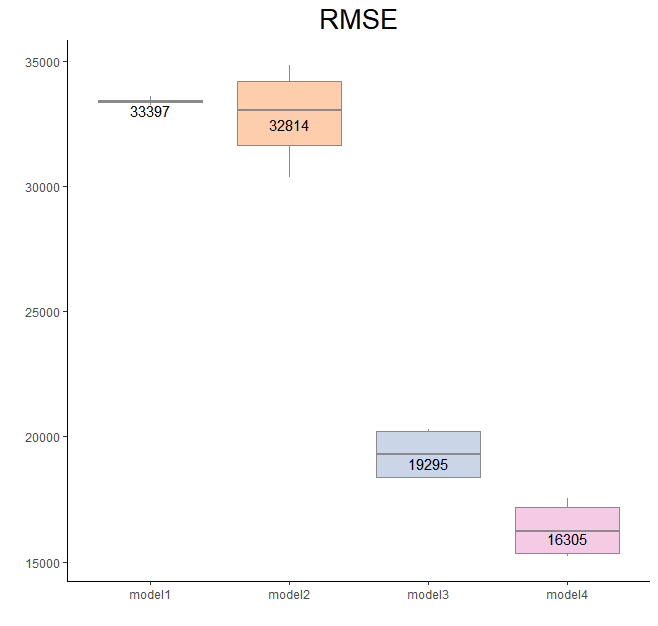

In [312]:
Image("model_RMSE.png")

### 결론 및 한계점
```
버스와 공공 자전거는 지하철 수요 예측에 중요한 변수임을 확인할 수 있었다.
추후 공간적 범위를 확대하여 2호선뿐만 아닌 전체 역에 대한 분석이 필요할 것으로 예상된다.
```

### 참고 문헌
* 초미세먼지 농도와 지하철 이용량의 관계분석과 미세먼지 대응정책의 실효성 평가(2019)

* A study on the number of passengers using the subway stations in Seoul-Department of Statistics, Ewha Womans University(2018)  

* 시계열 및 회귀분석을 활용한 휘발유가격의 광역권별․수단별 대중교통수요 영향력 비교분석(2014)

* 대도시의 대중교통수요 영향요인 분석(2019)

* 빅데이터 분석을 이용한 지하철 혼잡도 예측 및 추천시스템(2016)

* 비용효과분석을 통한 서울시 지하철 9호선 혼잡도 개선방안에 관한 연구(2017)

* 서울시 대중교통 수단별 월별 이용수요의 변동에 영향을 미치는 요인 분석(2017)

* 서울시 대중교통 이용 패턴 및 영향요인 분석 연구(2015)

* 대중교통 선택행태 및 이용 영향요인 분석 : 도시철도 및 버스 간 비교를 중심으로(2019)

* 기상조건이 대중교통수요에 미치는 영향에 관한 연구(2013)

* 교통카드 자료를 이용한 서울시 지역별 대중교통 수단 선택 공간상관성 분석(2013)

* 서울시 대중교통 이용 패턴 및 영향요인 분석 연구(2015)

* 스마트카드 자료를 활용한 대중교통 승객의 통행목적 추정(2019)

```
2호선 지하철 수요 예측
김도형 박사님 피드백

1) 총  대중교통 이용객수가 변함이 없다는 가정하에(물론 지하철 역이 신설되면 증가하겠지만) 
지하철역 신설전의 버스 이용객 수를 총 대중교통 이용객수로 두고 
"신설 후 버스 이용량 + 신설된 지하철 이용량 = 신설전 총 버스 이용량"
이런 식을 가정해 지하철 없는 지역의 데이터를 이용해 가상의 역이 신설됨을 가정해보면 재미있을것

2) 자전거 이용량과 시간의 상호작용이 들어가면 더 좋았을것
```